#### **Check GPU availability**

In [1]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Display GPU name
!nvidia-smi


Num GPUs Available: 1
Mon Feb 17 23:34:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------

#### **Configure Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to your dataset
import os
os.chdir('/content/drive/MyDrive/Severstal/severstal-1000/')  # Change this path


Mounted at /content/drive


#### **Install Dependencies**

In [3]:
!pip install tensorflow keras opencv-python matplotlib numpy albumentations

#### **Train Test Split**

In [4]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# Load CSV file
df = pd.read_csv('/content/drive/MyDrive/Severstal/severstal-1000/train.csv')

# Drop NaN (if any images do not have segmentation masks)
df = df.dropna(subset=['EncodedPixels'])

# Unique Image IDs
image_ids = df["ImageId"].unique()

# Train-Test-Validate Split (70-20-10)
train_ids, temp_ids = train_test_split(image_ids, test_size=0.30, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.66, random_state=42)  # 20% Test, 10% Validation

# Define directories
base_dir = "/content/drive/MyDrive/Severstal/severstal-1000/train_images/"
output_dir = "/content/dataset/"

for folder in ["train", "test", "validate"]:
    os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

# Function to move files
def move_files(image_list, dest_folder):
    for img in image_list:
        src_path = os.path.join(base_dir, img)
        dest_path = os.path.join(output_dir, dest_folder, img)
        shutil.copy(src_path, dest_path)

# Move images to respective folders
move_files(train_ids, "train")
move_files(test_ids, "test")
move_files(val_ids, "validate")

print(f"✅ Dataset split completed! Train: {len(train_ids)}, Test: {len(test_ids)}, Validate: {len(val_ids)}")


✅ Dataset split completed! Train: 700, Test: 198, Validate: 102


#### **U-Net Model Base**

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Enable Mixed Precision for Faster Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# U-Net Model with EfficientNet Backbone
def build_unet(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(input_shape)

    # EfficientNet as Backbone (Feature Extractor)
    backbone = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    backbone.trainable = False  # Freeze backbone during initial training

    # U-Net Decoder
    conv1 = Conv2D(256, (3, 3), activation="relu", padding="same")(backbone.output)
    up1 = UpSampling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(up1)
    up2 = UpSampling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(up2)
    up3 = UpSampling2D((2, 2))(conv3)

    conv4 = Conv2D(32, (3, 3), activation="relu", padding="same")(up3)
    up4 = UpSampling2D((2, 2))(conv4)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(up4)

    return Model(inputs, outputs)

# Compile Model
model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 7,386,276 (28.18 MB)

 Trainable params: 3,336,705 (12.73 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### **Splitting the train.csv file to three**

In [9]:
import pandas as pd
import os

# Load the original CSV
df = pd.read_csv('/content/drive/MyDrive/Severstal/severstal-1000/train.csv')

# Get the filenames from the images in each folder
train_images = set(os.listdir('/content/dataset/train/'))
validate_images = set(os.listdir('/content/dataset/validate/'))
test_images = set(os.listdir('/content/dataset/test/'))

# Filter the CSV rows based on the image filenames
train_df = df[df['ImageId'].isin(train_images)]
validate_df = df[df['ImageId'].isin(validate_images)]
test_df = df[df['ImageId'].isin(test_images)]

# Save the split dataframes to new CSV files
train_df.to_csv('/content/dataset/split_train.csv', index=False)
validate_df.to_csv('/content/dataset/split_validate.csv', index=False)
test_df.to_csv('/content/dataset/split_test.csv', index=False)

print("CSV files have been split and saved!")


CSV files have been split and saved!


#### **Train the Model**

In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

# Convert RLE to binary mask
def rle_to_mask(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    rle = list(map(int, rle.split()))

    for i in range(0, len(rle), 2):
        start = rle[i] - 1  # 1-based index in RLE, so subtract 1
        length = rle[i+1]
        mask[start:start+length] = 1

    return mask.reshape(shape).T  # Return reshaped mask

# U-Net with pretrained ResNet50 as backbone
def unet_resnet(input_size=(256, 256, 3)):
    # Pretrained ResNet50 model (encoder)
    base_model = ResNet50(input_shape=input_size, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the layers of the pretrained model

    # Encoder
    encoder_output = base_model.output

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(encoder_output)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((4, 4))(x)  # Final upsampling to match the input size

    # Output layer (single channel for binary classification)
    output = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)

    # Define the model
    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Data Generator for RLE mask handling
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, image_size, shuffle=True):
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        masks = []

        for _, row in batch_df.iterrows():
            image_id = row['ImageId']
            img = tf.keras.preprocessing.image.load_img(os.path.join(self.image_dir, image_id), target_size=self.image_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Get the RLE from CSV and convert it to a mask
            rle = row['EncodedPixels']
            mask = rle_to_mask(rle, shape=self.image_size)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Load the train and validation CSV files
train_df = pd.read_csv('/content/dataset/split_train.csv')
validation_df = pd.read_csv('/content/dataset/split_validate.csv')

# Set paths
train_dir = '/content/dataset/train/'
val_dir = '/content/dataset/validate/'

# Parameters
image_size = (256, 256)  # Resize images to 256x256
batch_size = 32

# Initialize the data generators
train_generator = SegmentationDataGenerator(train_df, train_dir, batch_size, image_size)
val_generator = SegmentationDataGenerator(validation_df, val_dir, batch_size, image_size)

# Create U-Net model with ResNet50 backbone
model = unet_resnet(input_size=(256, 256, 3))

# Model Checkpoint callback to save the best model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Severstal/severstal-1000/severstal_model_resnet_unet.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint]
)

# Save the model
model.save('/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras')
print("✅ Model training complete & saved!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 463ms/step - accuracy: 0.8772 - loss: 0.3854 - val_accuracy: 0.9526 - val_loss: 0.2152
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9589 - loss: 0.1976 - val_accuracy: 0.9471 - val_loss: 0.2343
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.9581 - loss: 0.1804 - val_accuracy: 0.9498 - val_loss: 0.2002
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.9585 - loss: 0.1732 - val_accuracy: 0.9512 - val_loss: 0.1844
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9648 - loss: 0.1573 - val_accuracy: 0.9506 - val_loss: 0.2136
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.9603 - loss: 0.1769 - val_accuracy: 0.9529 - val_loss: 0.2059
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9599 - loss: 0.1787 - val_accuracy: 0.9539 - val_loss: 0.2315
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9652 - loss: 0.1538 - val_accuracy: 0

#### **Inference**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


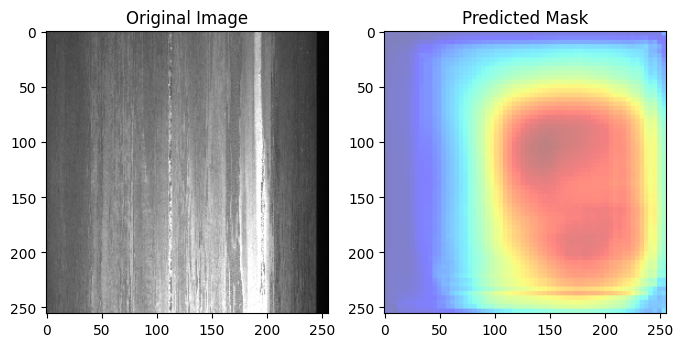

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras")

# Load Test Image
test_img_path = "/content/drive/MyDrive/Severstal/severstal-1000/inference_test/00d72c660.jpg"
test_img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(256, 256))
test_img = np.array(test_img) / 255.0  # Normalize
test_img = np.expand_dims(test_img, axis=0)

# Predict Mask
pred_mask = model.predict(test_img)[0]
pred_mask = np.squeeze(pred_mask)  # Remove extra dimensions

# Show Results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img), cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="jet", alpha=0.5)
plt.title("Predicted Mask")

plt.show()


#### Masking based on threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


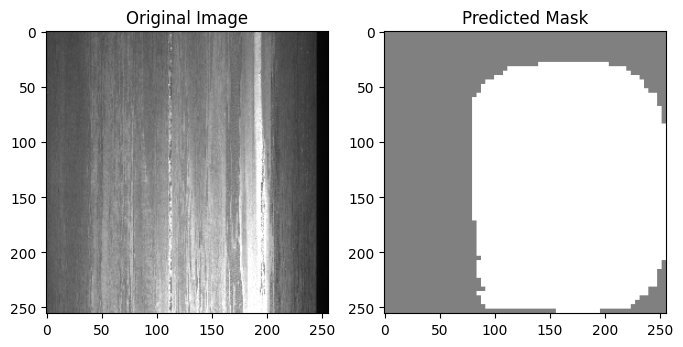

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras")

# Load Test Image
test_img_path = "/content/drive/MyDrive/Severstal/severstal-1000/inference_test/00d72c660.jpg"
test_img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(256, 256))
test_img = np.array(test_img) / 255.0  # Normalize
test_img = np.expand_dims(test_img, axis=0)

# Predict Mask
pred_mask = model.predict(test_img)[0]
pred_mask = np.squeeze(pred_mask)  # Remove extra dimensions

# Threshold the mask to convert to binary (0 or 1)
threshold = 0.05  # This can be adjusted
binary_mask = (pred_mask > threshold).astype(np.uint8)

# Show Results
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img), cmap="gray")
plt.title("Original Image")

# Predicted Mask in black and white (thresholded to 0 or 1)
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray", alpha=0.5)
plt.title("Predicted Mask")

plt.show()


#### **With ground truth**

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Convert RLE to binary mask (handles multiple RLEs)
def rle_to_mask(rles, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)  # Initialize mask with zeros
    for rle in rles:
        rle = list(map(int, rle.split()))  # Convert RLE to list of integers
        for i in range(0, len(rle), 2):
            start = rle[i] - 1  # 1-based index, so subtract 1 for 0-based indexing
            length = rle[i+1]
            mask[start:start+length] = 1  # Mark the mask with 1 for the specified range
    return mask.reshape(shape).T  # Reshape and transpose to get the mask

# Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras")

# Load Test Image
def test_inference(model, test_path):
  test_img_path = f"/content/drive/MyDrive/Severstal/severstal-1000/inference_test/{test_path}"
  test_img = load_img(test_img_path, target_size=(256, 256))
  test_img = img_to_array(test_img) / 255.0  # Normalize
  test_img = np.expand_dims(test_img, axis=0)

  # Predict Mask
  pred_mask = model.predict(test_img)[0]
  print(f"Predictions : {pred_mask}")
  pred_mask = np.squeeze(pred_mask)  # Remove extra dimensions

  # Threshold the mask to convert to binary (0 or 1)
  threshold = 0.007  # This can be adjusted
  binary_mask = (pred_mask > threshold).astype(np.uint8)

  # Read train.csv to get the RLE for the test image
  train_df = pd.read_csv('/content/drive/MyDrive/Severstal/severstal-1000/train.csv')

  # Extract the RLE for the specific test image
  image_name = test_path  # Ensure this matches the test image
  rles = train_df[train_df['ImageId'] == image_name]['EncodedPixels'].values

  # Convert RLE to binary mask (ground truth)
  if len(rles) > 0:
      print("Rle found")
      ground_truth_mask = rle_to_mask(rles, shape=(1600, 256))
  else:
      ground_truth_mask = np.zeros((1600, 256), dtype=np.uint8)  # In case RLE is missing

  # Show Results
  plt.figure(figsize=(12, 4))

  # Original Image
  plt.subplot(1, 3, 1)
  plt.imshow(np.squeeze(test_img), cmap="gray")
  plt.title("Original Image")

  # Ground Truth Mask
  plt.subplot(1, 3, 2)
  plt.imshow(ground_truth_mask, cmap="gray", alpha=0.5)
  plt.title("Ground Truth Mask")

  # Predicted Mask in black and white (thresholded to 0 or 1)
  plt.subplot(1, 3, 3)
  plt.imshow(binary_mask, cmap="gray", alpha=0.5)
  plt.title("Predicted Mask")

  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predictions : [[[0.0007153]
  [0.0007153]
  [0.0007153]
  ...
  [0.02037  ]
  [0.02037  ]
  [0.02037  ]]

 [[0.0007153]
  [0.0007153]
  [0.0007153]
  ...
  [0.02037  ]
  [0.02037  ]
  [0.02037  ]]

 [[0.0007153]
  [0.0007153]
  [0.0007153]
  ...
  [0.02037  ]
  [0.02037  ]
  [0.02037  ]]

 ...

 [[0.00438  ]
  [0.00438  ]
  [0.00438  ]
  ...
  [0.0323   ]
  [0.0323   ]
  [0.0323   ]]

 [[0.00438  ]
  [0.00438  ]
  [0.00438  ]
  ...
  [0.0323   ]
  [0.0323   ]
  [0.0323   ]]

 [[0.00438  ]
  [0.00438  ]
  [0.00438  ]
  ...
  [0.0323   ]
  [0.0323   ]
  [0.0323   ]]]
Rle found


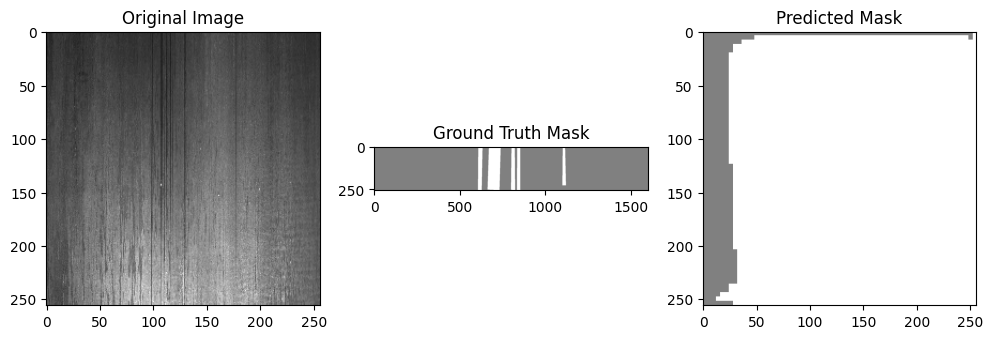

In [51]:
test_inference(model, "00af2671f.jpg")

#### **Different Implemetation**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.2066 - loss: 1.6671 - val_accuracy: 0.0833 - val_loss: 0.6401
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 628ms/step - accuracy: 0.1592 - loss: 0.5908 - val_accuracy: 0.4375 - val_loss: 0.4840
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 581ms/step - accuracy: 0.4171 - loss: 0.4786 - val_accuracy: 0.6562 - val_loss: 0.5119
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.6427 - loss: 0.4874 - val_accuracy: 0.7292 - val_loss: 0.4894
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 636ms/step - accuracy: 0.7058 - loss: 0.4229 - val_accuracy: 0.7500 - val_loss: 0.4651
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - accuracy: 0.6959 - loss: 0.4816 - val_accuracy: 0.7188 - val_loss: 0.4861
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 525ms/step - accuracy: 0.7021 - loss: 0.4995 - val_accuracy: 0.7188 - val_loss: 0.4798
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 602ms/step - accuracy: 0.6923 - loss: 0.5037 - val_accura

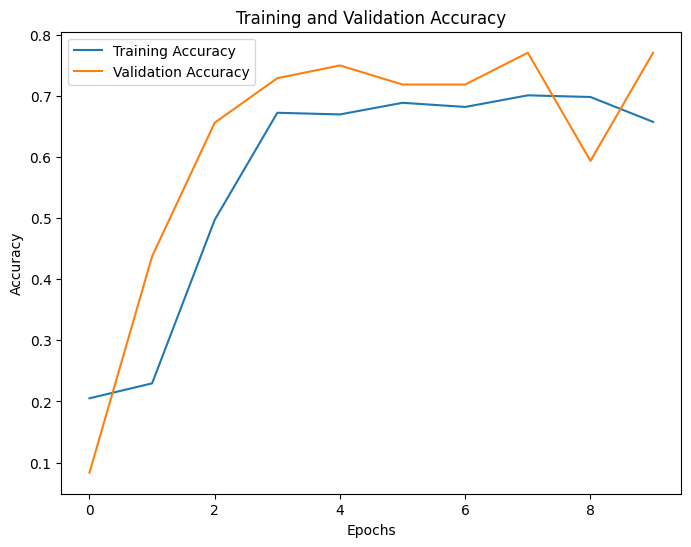

✅ Model training complete & saved!


In [59]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


# Convert RLE to binary mask (flattened version)
def rle_to_mask(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    rle = list(map(int, rle.split()))

    for i in range(0, len(rle), 2):
        start = rle[i] - 1  # 1-based index in RLE, so subtract 1
        length = rle[i+1]
        mask[start:start+length] = 1

    return mask  # Return flattened mask as 1D vector

# U-Net with pretrained ResNet50 as backbone
def unet_resnet(input_size=(1600, 256, 3)):
    # Pretrained ResNet50 model (encoder)
    base_model = ResNet50(input_shape=input_size, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the layers of the pretrained model

    # Encoder
    encoder_output = base_model.output

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(encoder_output)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((4, 4))(x)  # Final upsampling to match the input size
    x = layers.Conv2D(filters=8, kernel_size=(8, 1), strides=(8, 1), padding='same')(x)

    # Output layer (single channel for binary classification, flattened to 1D vector)
    #output = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)
    output = layers.Reshape((input_size[0] * input_size[1],))(x)  # Flatten output to 1D vector

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Data Generator for RLE mask handling (produces flattened 1D mask)
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, image_size, shuffle=True):
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        masks = []

        for _, row in batch_df.iterrows():
            image_id = row['ImageId']
            img = tf.keras.preprocessing.image.load_img(os.path.join(self.image_dir, image_id), target_size=self.image_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Get the RLE from CSV and convert it to a mask
            rle = row['EncodedPixels']
            mask = rle_to_mask(rle, shape=self.image_size)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Load the train and validation CSV files
train_df = pd.read_csv('/content/dataset/split_train.csv')
validation_df = pd.read_csv('/content/dataset/split_validate.csv')

# Set paths
train_dir = '/content/dataset/train/'
val_dir = '/content/dataset/validate/'

# Parameters
image_size = (1600, 256)  # Resize images to 256x256
batch_size = 32

# Initialize the data generators
train_generator = SegmentationDataGenerator(train_df, train_dir, batch_size, image_size)
val_generator = SegmentationDataGenerator(validation_df, val_dir, batch_size, image_size)

# Create U-Net model with ResNet50 backbone
model = unet_resnet(input_size=(1600, 256, 3))

# Model Checkpoint callback to save the best model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Severstal/severstal-1000/severstal_model_resnet_unet.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint]
)


# Extract accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(8, 6))

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


# Save the model
model.save('/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras')
print("✅ Model training complete & saved!")


#### **Running for 100 epochs**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 838ms/step - accuracy: 0.3217 - loss: 1.8591 - val_accuracy: 0.5312 - val_loss: 0.7336
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - accuracy: 0.3367 - loss: 0.7948 - val_accuracy: 0.8021 - val_loss: 0.7464
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 651ms/step - accuracy: 0.2509 - loss: 0.4882 - val_accuracy: 0.2500 - val_loss: 0.2945
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.2821 - loss: 0.3249 - val_accuracy: 0.3333 - val_loss: 0.2934
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.4255 - loss: 0.2810 - val_accuracy: 0.5729 - val_loss: 0.3241
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.5217 - loss: 0.3139 - val_accuracy: 0.6250 - val_loss: 0.3079
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.6000 - loss: 0.3085 - val_accuracy: 0.6979 - val_loss: 0.3095
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 533ms/step - accuracy: 0.6374 - loss: 0.2999 - 

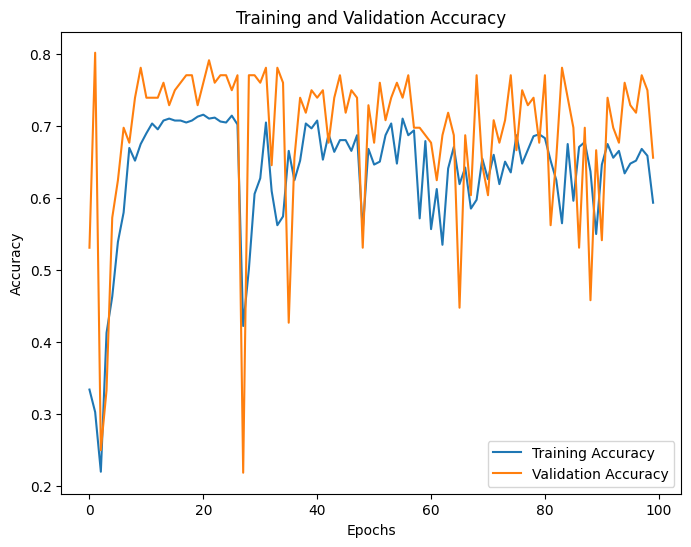

✅ Model training complete & saved!


In [60]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


# Convert RLE to binary mask (flattened version)
def rle_to_mask(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    rle = list(map(int, rle.split()))

    for i in range(0, len(rle), 2):
        start = rle[i] - 1  # 1-based index in RLE, so subtract 1
        length = rle[i+1]
        mask[start:start+length] = 1

    return mask  # Return flattened mask as 1D vector

# U-Net with pretrained ResNet50 as backbone
def unet_resnet(input_size=(1600, 256, 3)):
    # Pretrained ResNet50 model (encoder)
    base_model = ResNet50(input_shape=input_size, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the layers of the pretrained model

    # Encoder
    encoder_output = base_model.output

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(encoder_output)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((4, 4))(x)  # Final upsampling to match the input size
    x = layers.Conv2D(filters=8, kernel_size=(8, 1), strides=(8, 1), padding='same')(x)

    # Output layer (single channel for binary classification, flattened to 1D vector)
    #output = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)
    output = layers.Reshape((input_size[0] * input_size[1],))(x)  # Flatten output to 1D vector

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Data Generator for RLE mask handling (produces flattened 1D mask)
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, image_size, shuffle=True):
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        masks = []

        for _, row in batch_df.iterrows():
            image_id = row['ImageId']
            img = tf.keras.preprocessing.image.load_img(os.path.join(self.image_dir, image_id), target_size=self.image_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Get the RLE from CSV and convert it to a mask
            rle = row['EncodedPixels']
            mask = rle_to_mask(rle, shape=self.image_size)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Load the train and validation CSV files
train_df = pd.read_csv('/content/dataset/split_train.csv')
validation_df = pd.read_csv('/content/dataset/split_validate.csv')

# Set paths
train_dir = '/content/dataset/train/'
val_dir = '/content/dataset/validate/'

# Parameters
image_size = (1600, 256)  # Resize images to 256x256
batch_size = 32

# Initialize the data generators
train_generator = SegmentationDataGenerator(train_df, train_dir, batch_size, image_size)
val_generator = SegmentationDataGenerator(validation_df, val_dir, batch_size, image_size)

# Create U-Net model with ResNet50 backbone
model = unet_resnet(input_size=(1600, 256, 3))

# Model Checkpoint callback to save the best model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Severstal/severstal-1000/severstal_model_resnet_unet.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint]
)


# Extract accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(8, 6))

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


# Save the model
model.save('/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras')
print("✅ Model training complete & saved!")

In [61]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras")


In [73]:
# Convert RLE to binary mask (handles multiple RLEs)
def rle_to_mask(rles, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)  # Initialize mask with zeros
    for rle in rles:
        rle = list(map(int, rle.split()))  # Convert RLE to list of integers
        for i in range(0, len(rle), 2):
            start = rle[i] - 1  # 1-based index, so subtract 1 for 0-based indexing
            length = rle[i+1]
            mask[start:start+length] = 1  # Mark the mask with 1 for the specified range
    return mask.reshape(shape).T  # Reshape and transpose to get the mask

# Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final.keras")

# Load Test Image
def test_inference(model, test_path):
  test_img_path = f"/content/drive/MyDrive/Severstal/severstal-1000/inference_test/{test_path}"
  test_img = load_img(test_img_path, target_size=(1600, 256))
  test_img = img_to_array(test_img) / 255.0  # Normalize
  test_img = np.expand_dims(test_img, axis=0)

  # Predict Mask
  pred_mask = model.predict(test_img)[0]
  pred_mask = pred_mask.reshape(1600, 256)
  print(f"Predictions : {pred_mask}")
  pred_mask = np.squeeze(pred_mask)  # Remove extra dimensions

  # Threshold the mask to convert to binary (0 or 1)
  threshold = 0.01  # This can be adjusted
  binary_mask = (pred_mask < threshold).astype(np.uint8)

  # Read train.csv to get the RLE for the test image
  train_df = pd.read_csv('/content/drive/MyDrive/Severstal/severstal-1000/train.csv')

  # Extract the RLE for the specific test image
  image_name = test_path  # Ensure this matches the test image
  rles = train_df[train_df['ImageId'] == image_name]['EncodedPixels'].values

  # Convert RLE to binary mask (ground truth)
  if len(rles) > 0:
      print("Rle found")
      ground_truth_mask = rle_to_mask(rles, shape=(1600, 256))
  else:
      ground_truth_mask = np.zeros((1600, 256), dtype=np.uint8)  # In case RLE is missing

  # Show Results
  plt.figure(figsize=(12, 4))

  # Original Image
  plt.subplot(1, 3, 1)
  plt.imshow(np.squeeze(test_img), cmap="gray")
  plt.title("Original Image")

  # Ground Truth Mask
  plt.subplot(1, 3, 2)
  plt.imshow(ground_truth_mask, cmap="gray", alpha=0.5)
  plt.title("Ground Truth Mask")

  # Predicted Mask in black and white (thresholded to 0 or 1)
  plt.subplot(1, 3, 3)
  plt.imshow(binary_mask, cmap="gray", alpha=0.5)
  plt.title("Predicted Mask")

  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predictions : [[0.01149  0.01282  0.02588  ... 0.0179   0.01778  0.01199 ]
 [0.01154  0.007225 0.02126  ... 0.01834  0.01819  0.011406]
 [0.00972  0.008    0.0213   ... 0.01778  0.01782  0.01444 ]
 ...
 [0.01637  0.01619  0.01772  ... 0.01707  0.01683  0.01807 ]
 [0.01637  0.01619  0.01772  ... 0.01707  0.01683  0.01807 ]
 [0.01637  0.01619  0.01772  ... 0.0177   0.01668  0.01868 ]]
Rle found


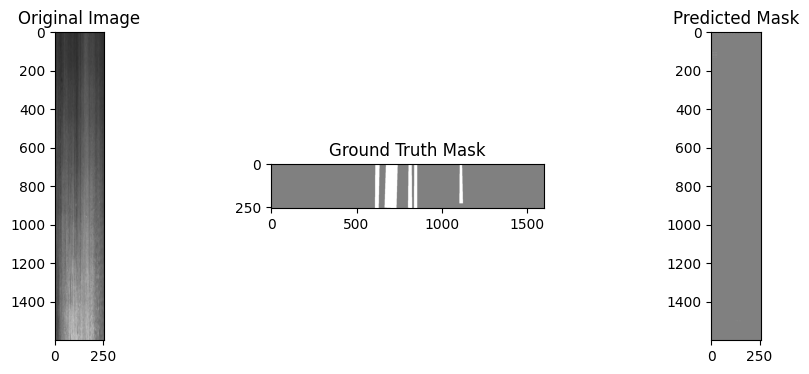

In [74]:
test_inference(model, "00af2671f.jpg")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 844ms/step - accuracy: 0.3519 - loss: 0.5098 - val_accuracy: 0.7708 - val_loss: 0.2353
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 894ms/step - accuracy: 0.5068 - loss: 0.2255 - val_accuracy: 0.0000e+00 - val_loss: 0.2225
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 561ms/step - accuracy: 0.0055 - loss: 0.2404 - val_accuracy: 0.7917 - val_loss: 0.2257
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 549ms/step - accuracy: 0.5189 - loss: 0.2308 - val_accuracy: 0.0000e+00 - val_loss: 0.2283
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 608ms/step - accuracy: 0.1147 - loss: 0.2207 - val_accuracy: 0.0417 - val_loss: 0.2130
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 576ms/step - accuracy: 0.0906 - loss: 0.2366 - val_accuracy: 0.2083 - val_loss: 0.2242
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 549ms/step - accuracy: 0.5033 - loss: 0.2420 - val_accuracy: 0.1667 - val_loss: 0.2244
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.3828 - loss: 0.2452 - 

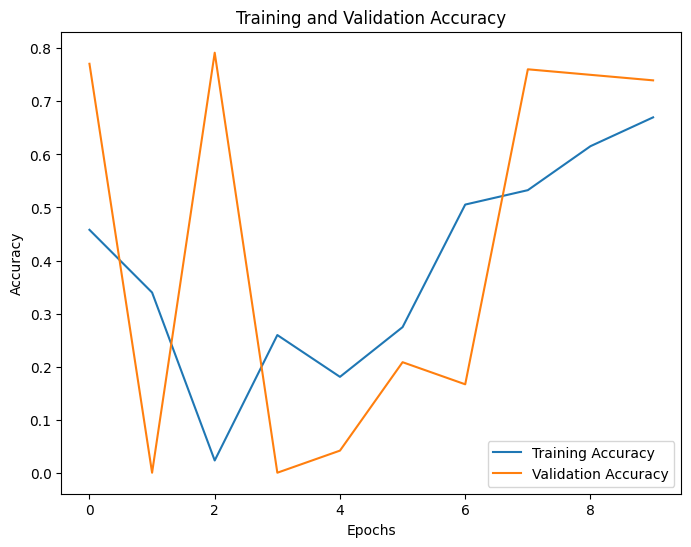

✅ Model training complete & saved!


In [76]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


# Convert RLE to binary mask (flattened version)
def rle_to_mask(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    rle = list(map(int, rle.split()))

    for i in range(0, len(rle), 2):
        start = rle[i] - 1  # 1-based index in RLE, so subtract 1
        length = rle[i+1]
        mask[start:start+length] = 1

    return mask  # Return flattened mask as 1D vector

# U-Net with pretrained ResNet50 as backbone
def unet_resnet(input_size=(1600, 256, 3)):
    # Pretrained ResNet50 model (encoder)
    base_model = ResNet50(input_shape=input_size, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the layers of the pretrained model

    # Encoder
    encoder_output = base_model.output

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(encoder_output)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((4, 4))(x)  # Final upsampling to match the input size
    x = layers.Conv2D(filters=8, kernel_size=(8, 1), strides=(8, 1), padding='same', activation="sigmoid")(x)

    # Output layer (single channel for binary classification, flattened to 1D vector)
    #output = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)
    output = layers.Reshape((input_size[0] * input_size[1],))(x)  # Flatten output to 1D vector

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Data Generator for RLE mask handling (produces flattened 1D mask)
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, image_size, shuffle=True):
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        masks = []

        for _, row in batch_df.iterrows():
            image_id = row['ImageId']
            img = tf.keras.preprocessing.image.load_img(os.path.join(self.image_dir, image_id), target_size=self.image_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Get the RLE from CSV and convert it to a mask
            rle = row['EncodedPixels']
            mask = rle_to_mask(rle, shape=self.image_size)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Load the train and validation CSV files
train_df = pd.read_csv('/content/dataset/split_train.csv')
validation_df = pd.read_csv('/content/dataset/split_validate.csv')

# Set paths
train_dir = '/content/dataset/train/'
val_dir = '/content/dataset/validate/'

# Parameters
image_size = (1600, 256)  # Resize images to 256x256
batch_size = 32

# Initialize the data generators
train_generator = SegmentationDataGenerator(train_df, train_dir, batch_size, image_size)
val_generator = SegmentationDataGenerator(validation_df, val_dir, batch_size, image_size)

# Create U-Net model with ResNet50 backbone
model = unet_resnet(input_size=(1600, 256, 3))

# Model Checkpoint callback to save the best model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Severstal/severstal-1000/severstal_model_resnet_unet_sigmoid_10.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint]
)


# Extract accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(8, 6))

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


# Save the model
model.save('/content/drive/MyDrive/Severstal/severstal-1000/severstal_resnet_unet_final_sigmoid_10.keras')
print("✅ Model training complete & saved!")